# Handwritten digits recognition (using Convolutional Neural Network)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**<br/><br/>
> - ▶️ **Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments/)

## Experiment overview

In this experiment we will build a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) model using [Tensorflow](https://www.tensorflow.org/) to recognize handwritten digits.

A **convolutional neural network** (CNN, or ConvNet) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

![digits_recognition_cnn.png](https://github.com/trekhleb/machine-learning-experiments/blob/master/demos/src/images/digits_recognition_cnn.png?raw=1)

## Import dependencies

- [tensorflow](https://www.tensorflow.org/) - for developing and training ML models.
- [matplotlib](https://matplotlib.org/) - for plotting the data.
- [seaborn](https://seaborn.pydata.org/index.html) - for plotting confusion matrix.
- [numpy](https://numpy.org/) - for linear algebra operations.
- [pandas](https://pandas.pydata.org/) - for displaying training/test data in a table.
- [math](https://docs.python.org/3/library/math.html) - for calculating square roots etc.
- [datetime](https://docs.python.org/3.8/library/datetime.html) - for generating a logs folder names.

In [ ]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
import datetime
import platform

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Configuring Tensorboard

We will use [Tensorboard](https://www.tensorflow.org/tensorboard) to debug the model later.

In [ ]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs.
!rm -rf ./.logs/

## Load the data

The **training** dataset consists of 60000 28x28px images of hand-written digits from `0` to `9`.

The **test** dataset consists of 10000 28x28px images.

In [ ]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

In [ ]:
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [ ]:
# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train.shape
IMAGE_CHANNELS = 1

print('IMAGE_WIDTH:', IMAGE_WIDTH);
print('IMAGE_HEIGHT:', IMAGE_HEIGHT);
print('IMAGE_CHANNELS:', IMAGE_CHANNELS);

IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1


## Explore the data

Here is how each image in the dataset looks like. It is a 28x28 matrix of integers (from `0` to `255`). Each integer represents a color of a pixel.

In [1]:
pd.DataFrame(x_train[0])

NameError: ignored

This matrix of numbers may be drawn as follows: 

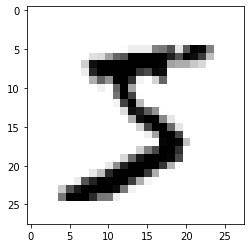

In [ ]:
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()

Let's print some more training examples to get the feeling of how the digits were written.

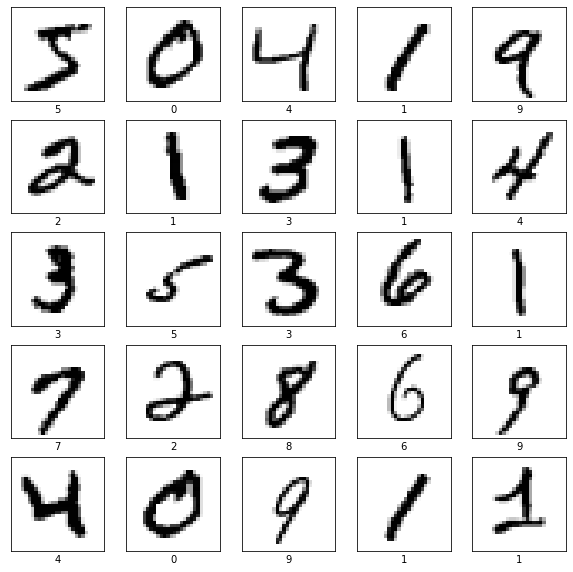

In [ ]:
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

## Reshaping the data

In order to use convolution layers we need to reshape our data and add a color channel to it. As you've noticed currently every digit has a shape of `(28, 28)` which means that it is a 28x28 matrix of color values form `0` to `255`. We need to reshape it to `(28, 28, 1)` shape so that each pixel potentially may have multiple channels (like Red, Green and Blue).

In [ ]:
x_train_with_chanels = x_train.reshape(
    x_train.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_test_with_chanels = x_test.reshape(
    x_test.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

In [ ]:
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (60000, 28, 28, 1)
x_test_with_chanels: (10000, 28, 28, 1)


## Normalize the data

Here we're just trying to move from values range of `[0...255]` to `[0...1]`.

In [ ]:
x_train_normalized = x_train_with_chanels / 255
x_test_normalized = x_test_with_chanels / 255

In [ ]:
# Let's check just one row from the 0th image to see color chanel values after normalization.
x_train_normalized[0][18]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.18039216],
       [0.50980392],
       [0.71764706],
       [0.99215686],
       [0.99215686],
       [0.81176471],
       [0.00784314],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

## Build the model

We will use [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential?version=stable) Keras model.

Then we will have two pairs of [Convolution2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D?version=stable) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D?version=stable) layers. The MaxPooling layer acts as a sort of downsampling using max values in a region instead of averaging.

After that we will use [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten?version=stable) layer to convert multidimensional parameters to vector.

The las layer will be a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?version=stable) layer with `10` [Softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax?version=stable) outputs. The output represents the network guess. The 0-th output represents a probability that the input digit is `0`, the 1-st output represents a probability that the input digit is `1` and so on...


In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
));

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

Here is our model summary so far.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In order to plot the model the `graphviz` should be installed. For Mac OS it may be installed using `brew` like `brew install graphviz`.

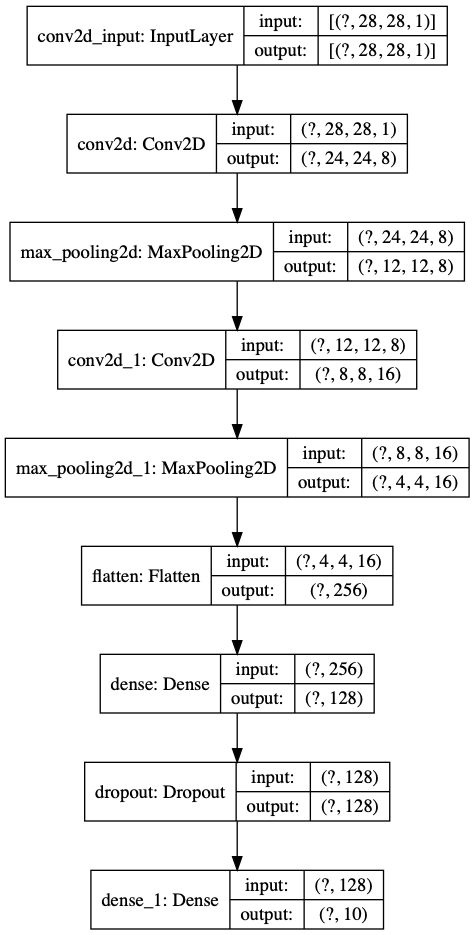

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Compile the model

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Train the model

In [ ]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    x_train_normalized,
    y_train,
    epochs=10,
    validation_data=(x_test_normalized, y_test),
    callbacks=[tensorboard_callback]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 494us/sample - loss: 0.2223 - accuracy: 0.9326 - val_loss: 0.0550 - val_accuracy: 0.9830
Epoch 2/10
60000/60000 [==============================] - 32s 538us/sample - loss: 0.0720 - accuracy: 0.9779 - val_loss: 0.0394 - val_accuracy: 0.9871
Epoch 3/10
60000/60000 [==============================] - 29s 488us/sample - loss: 0.0519 - accuracy: 0.9834 - val_loss: 0.0362 - val_accuracy: 0.9890
Epoch 4/10
60000/60000 [==============================] - 30s 494us/sample - loss: 0.0422 - accuracy: 0.9867 - val_loss: 0.0315 - val_accuracy: 0.9892
Epoch 5/10
60000/60000 [==============================] - 29s 484us/sample - loss: 0.0349 - accuracy: 0.9893 - val_loss: 0.0291 - val_accuracy: 0.9891
Epoch 6/10
60000/60000 [==============================] - 30s 492us/sample - loss: 0.0287 - accuracy: 0.9908 - val_loss: 0.0335 - val_accuracy: 0.9901
Epoch 7/10
60000/60000 [====================

Let's see how the loss function was changing during the training. We expect it to get smaller and smaller on every next epoch.

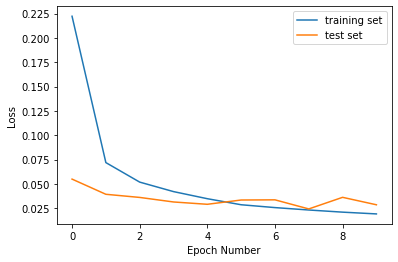

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='test set')
plt.legend()

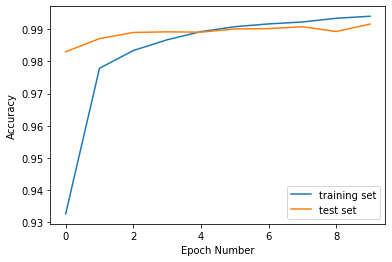

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['accuracy'], label='training set')
plt.plot(training_history.history['val_accuracy'], label='test set')
plt.legend()

## Evaluate model accuracy

We need to compare the accuracy of our model on **training** set and on **test** set. We expect our model to perform similarly on both sets. If the performance on a test set will be poor comparing to a training set it would be an indicator for us that the model is overfitted and we have a "high variance" issue.

### Training set accuracy

In [ ]:
%%capture
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train)

In [ ]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)

Training loss:  0.00793841718863229
Training accuracy:  0.9974


### Test set accuracy

In [ ]:
%%capture
validation_loss, validation_accuracy = model.evaluate(x_test_normalized, y_test)

In [ ]:
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

Validation loss:  0.028636791965250815
Validation accuracy:  0.9916


## Save the model

We will save the entire model to a `HDF5` file. The `.h5` extension of the file indicates that the model shuold be saved in Keras format as HDF5 file. To use this model on the front-end we will convert it (later in this notebook) to Javascript understandable format (`tfjs_layers_model` with .json and .bin files) using [tensorflowjs_converter](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model) as it is specified in the [main README](https://github.com/trekhleb/machine-learning-experiments).

In [ ]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')

In [ ]:
loaded_model = tf.keras.models.load_model(model_name)

## Use the model (do predictions)

To use the model that we've just trained for digits recognition we need to call `predict()` method.

In [3]:
predictions_one_hot = loaded_model.predict([x_test_normalized])

NameError: ignored

In [4]:
print('predictions_one_hot:', predictions_one_hot.shape)

NameError: ignored

Each prediction consists of 10 probabilities (one for each number from `0` to `9`). We need to pick the digit with the highest probability since this would be a digit that our model most confident with.

In [ ]:
# Predictions in form of one-hot vectors (arrays of probabilities).
pd.DataFrame(predictions_one_hot)

In [ ]:
# Let's extract predictions with highest probabilites and detect what digits have been actually recognized.
predictions = np.argmax(predictions_one_hot, axis=1)
pd.DataFrame(predictions)

So our model is predicting that the first example from the test set is `7`.

In [ ]:
print(predictions[0])

Let's print the first image from a test set to see if model's prediction is correct.

In [ ]:
plt.imshow(x_test_normalized[0].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

We see that our model made a correct prediction and it successfully recognized digit `7`. Let's print some more test examples and correspondent predictions to see how model performs and where it does mistakes.

In [ ]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

## Plotting a confusion matrix

[Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) shows what numbers are recognized well by the model and what numbers the model usually confuses to recognize correctly. You may see that the model performs really well but sometimes (28 times out of 10000) it may confuse number `5` with `3` or number `2` with `3`.

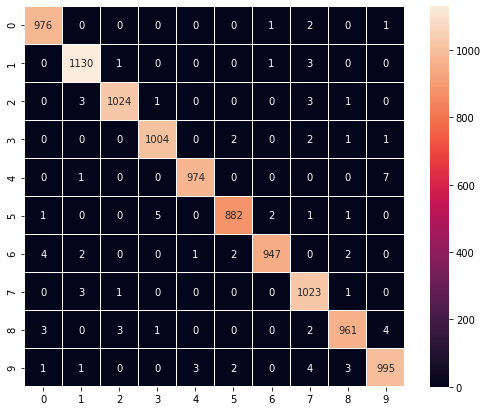

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## Debugging the model with TensorBoard

[TensorBoard](https://www.tensorflow.org/tensorboard) is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

In [2]:
%tensorboard --logdir .logs/fit

UsageError: Line magic function `%tensorboard` not found.


## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/digits_recognition_cnn/digits_recognition_cnn.h5 \
  ./demos/public/models/digits_recognition_cnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.